## Import necessary libraries

In [181]:
# basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# basic sklearn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

# unsupervised
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# supervised
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# neural net
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

# notebbok style
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

## Import data

In [3]:
data = load_wine()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.DataFrame(data.target, columns = ['class'])

print(X.shape, y.shape)

data = pd.concat([X, y], axis = 1)
#data['class'] = data['class'].astype('category')

data.head()

(178, 13) (178, 1)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Explore dataset

#### Target variable: 3 classes of wines

In [4]:
#data.groupby('class').count()
target_freq = pd.concat([data['class'].value_counts(), data['class'].value_counts(normalize=True) * 100], axis = 1, )
target_freq.columns = ['#', '%']
target_freq

,#,%
1,71,39.887640
0,59,33.146067
2,48,26.966292


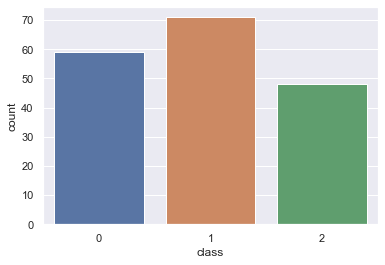

In [5]:
sns.countplot(x = "class", data = data)

#### Distributions of features

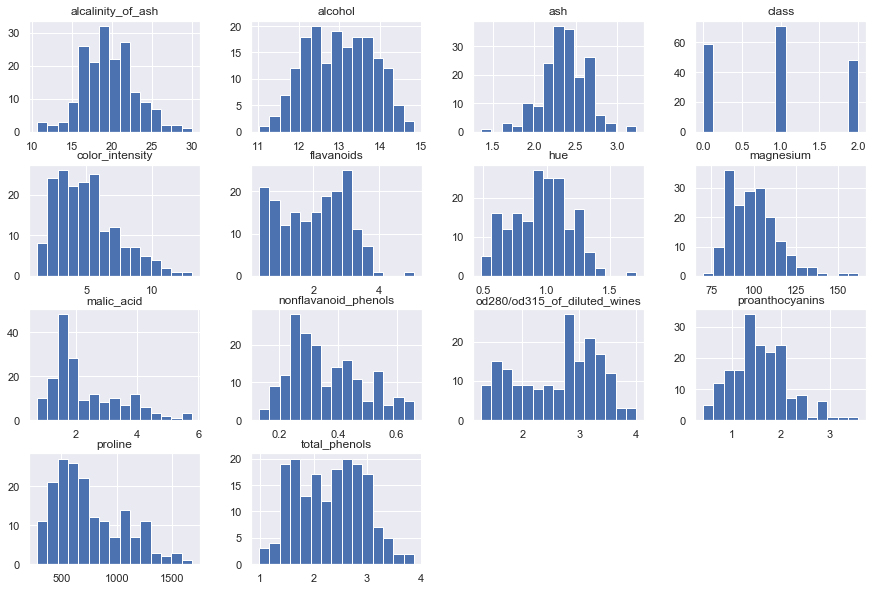

In [6]:
data.hist(bins = 15, figsize = (15, 10))
plt.show()

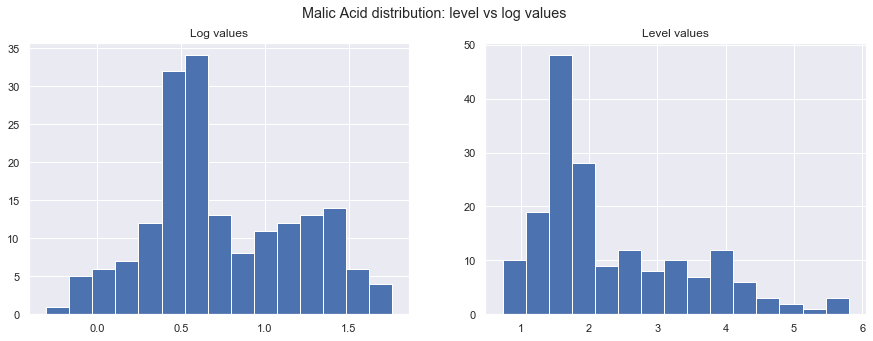

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Malic Acid distribution: level vs log values')

ax1.hist(np.log(data['malic_acid']), bins = 15, )
ax2.hist(data['malic_acid'], bins = 15)

ax1.set_title('Log values')
ax2.set_title('Level values')

plt.show()

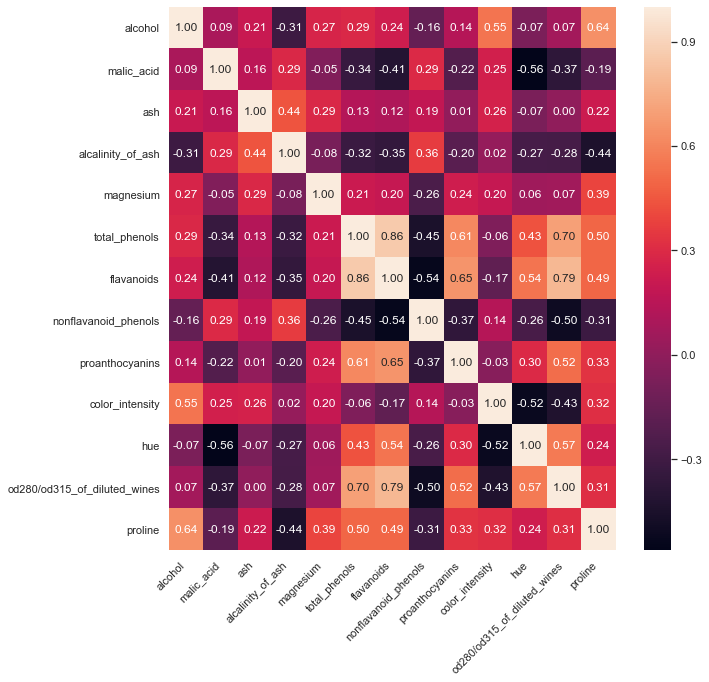

In [10]:
correlations = data.drop('class', 1).corr()

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlations, annot = True, fmt = ".2f")

ax.set_xticklabels(data.drop('class', 1).columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(data.drop('class', 1).columns)

plt.show()

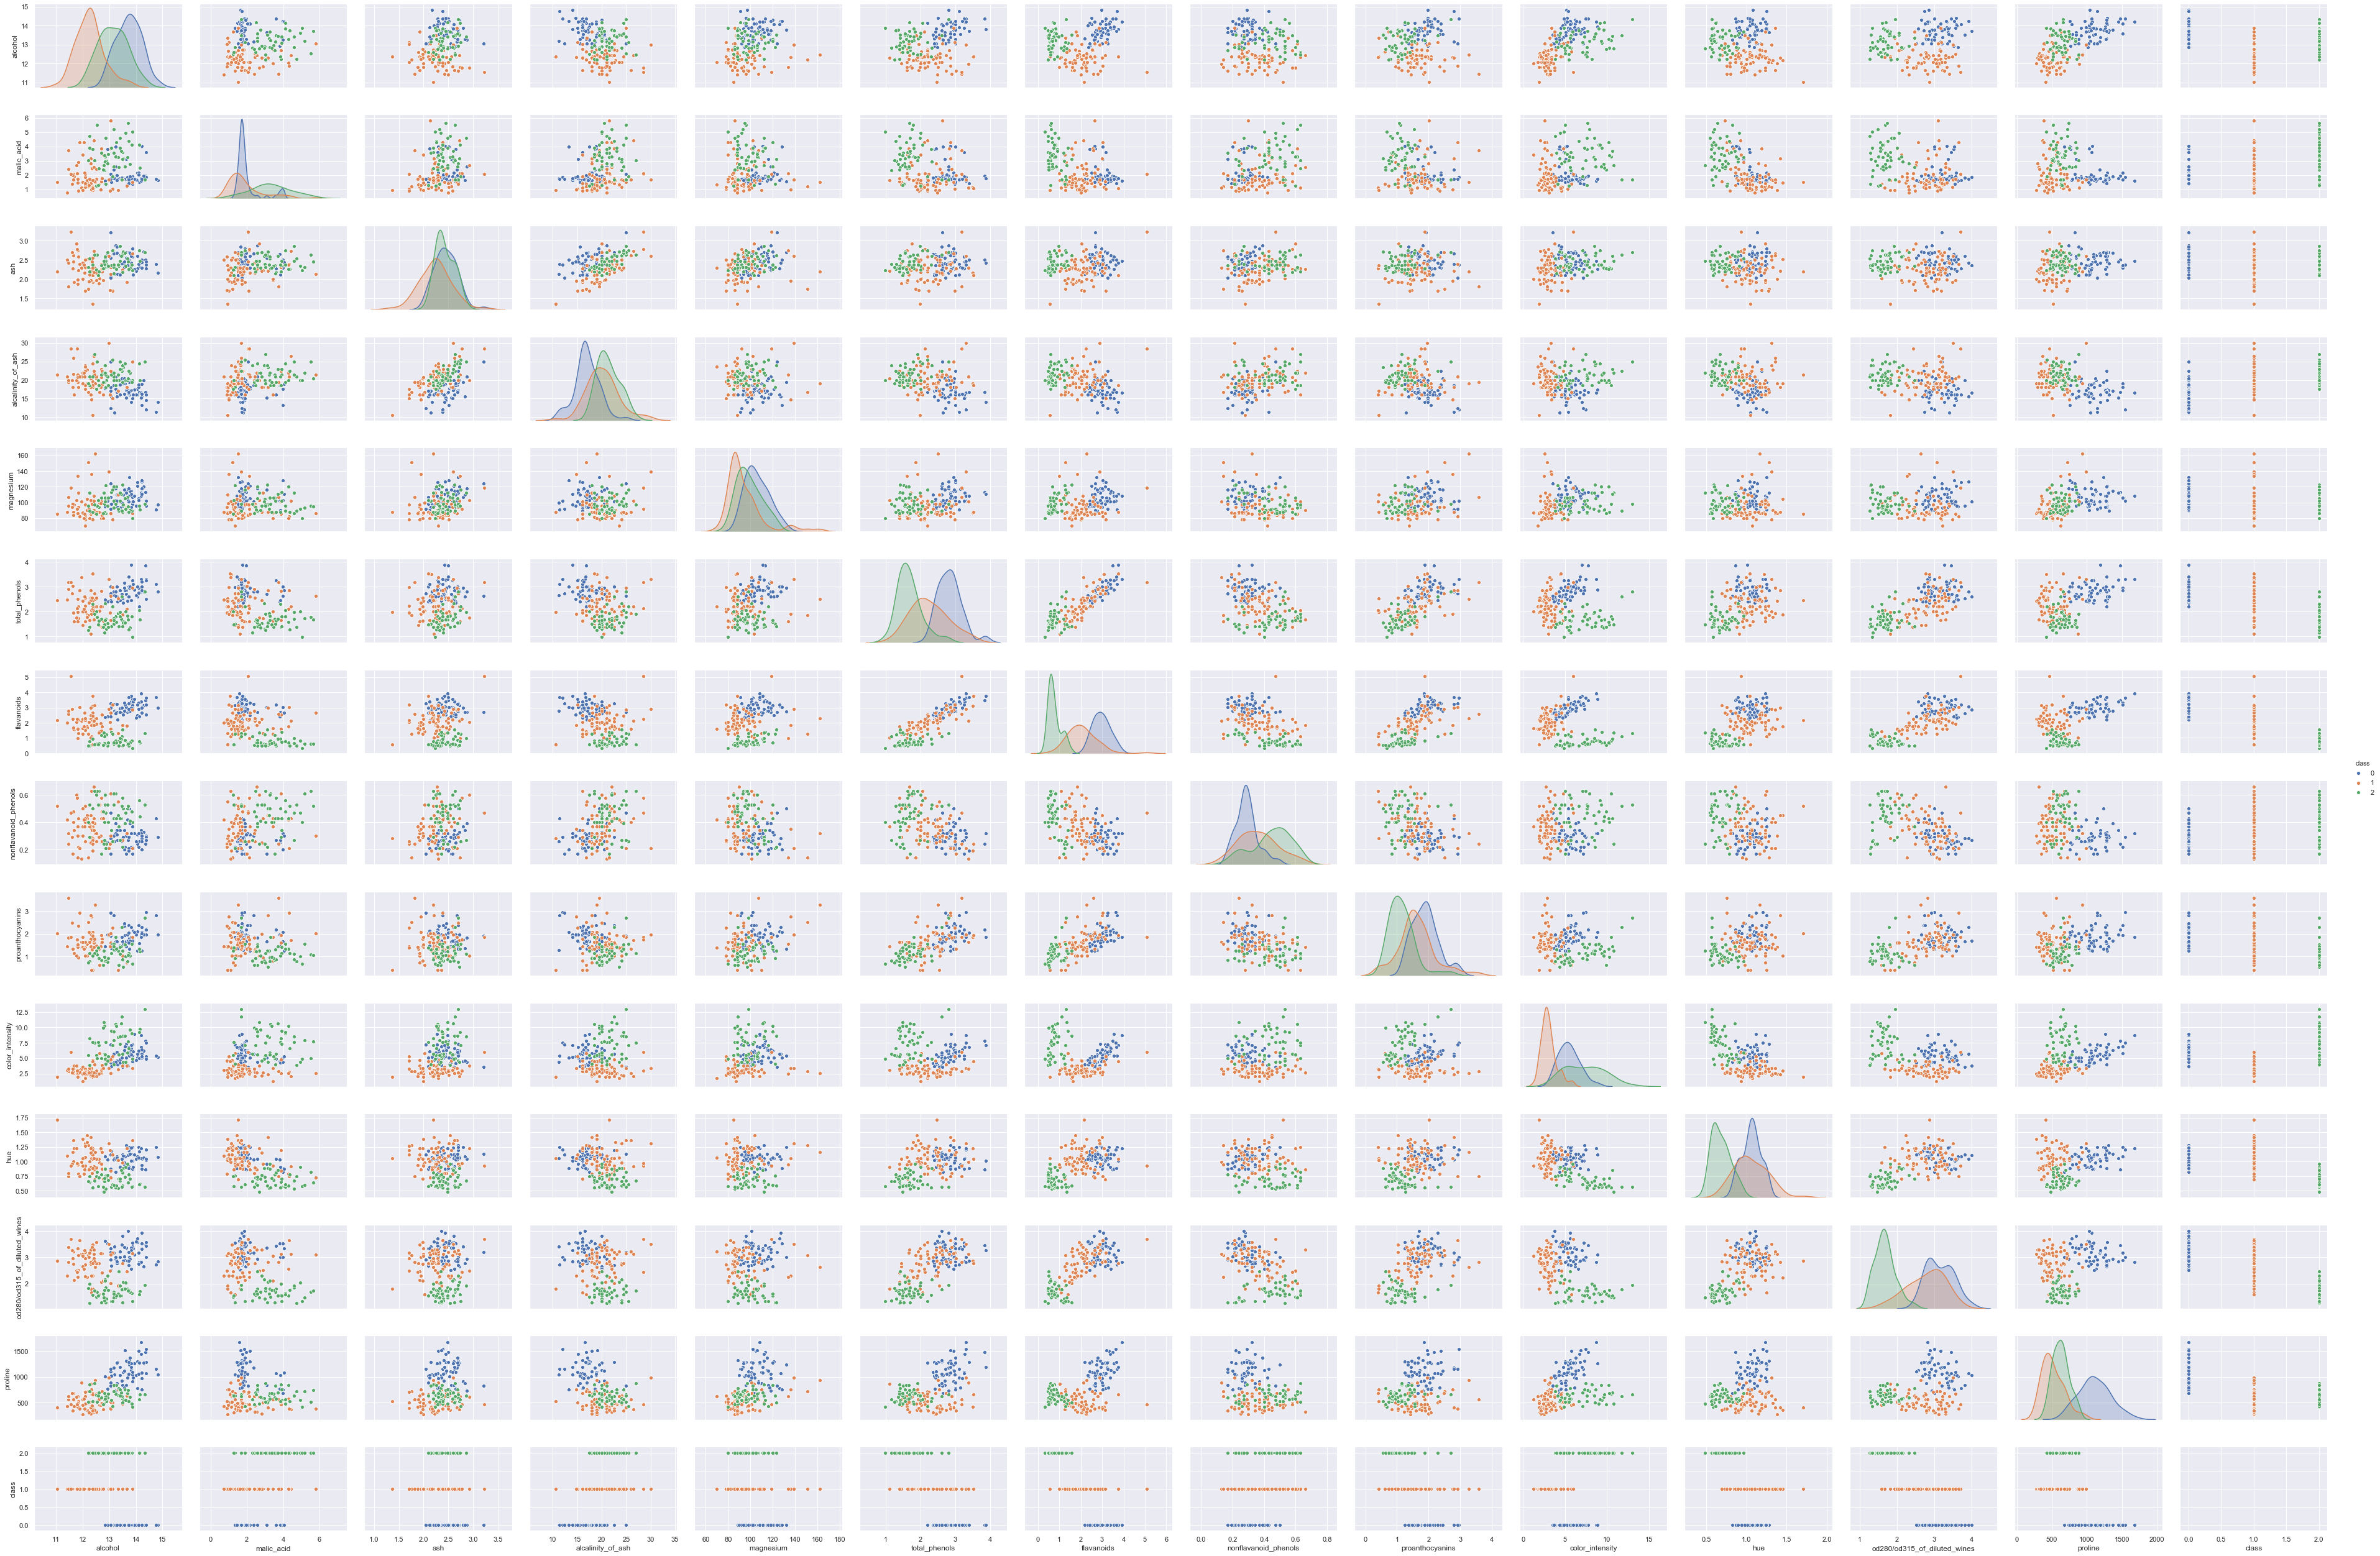

In [13]:
sns.pairplot(data, hue='class', aspect=1.5)
plt.show()

##### Feature engineering steps to take

1. Take the log of malic acid
2. Split to train & test
3. Scale all X features by StandardScaler()

##### 1. Taking the log of malic acid

In [14]:
data['malic_acid'] = np.log(data['malic_acid'])

##### 2. Train test split the data

In [15]:
X = data.drop('class', 1).copy()
y = data['class'].copy()

X.shape, y.shape

((178, 13), (178,))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 23)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(y_train.value_counts(normalize = True) * 100)
print(y_test.value_counts(normalize = True) * 100)

(124, 13) (124,) (54, 13) (54,)
1    38.709677
0    33.064516
2    28.225806
Name: class, dtype: float64
1    42.592593
0    33.333333
2    24.074074
Name: class, dtype: float64


##### 3. Scale features

In [17]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
109,11.61,0.300105,2.70,20.0,94.0,2.74,2.92,0.29,2.49,2.65,0.96,3.26,680.0
149,13.08,1.360977,2.36,21.5,113.0,1.41,1.39,0.34,1.14,9.40,0.57,1.33,550.0
176,13.17,0.951658,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0
126,12.43,0.425268,2.29,21.5,86.0,2.74,3.15,0.39,1.77,3.94,0.69,2.84,352.0
96,11.81,0.751416,2.74,21.5,134.0,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625.0


In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index = X_test.index, columns = X_test.columns)

X_train_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
109,-1.733963,-0.962976,1.245549,0.158942,-0.403110,0.786062,0.940893,-0.602127,1.621288,-1.040225,0.066295,0.923981,-0.211003
149,0.098414,1.404001,-0.033368,0.615163,1.020769,-1.420531,-0.620022,-0.200277,-0.775424,1.945197,-1.662953,-1.749543,-0.643747
176,0.210601,0.490745,0.004247,0.158942,1.545355,-1.022349,-1.344367,1.326754,-0.207314,1.900968,-1.529934,-1.347821,0.321605
126,-0.711820,-0.683716,-0.296675,0.615163,-1.002638,0.786062,1.175540,0.201573,0.343042,-0.469678,-1.130877,0.342178,-1.302850
96,-1.484660,0.043973,1.396010,0.615163,2.594529,-1.105303,-1.028104,-1.807678,-0.029780,-1.106568,0.021955,-0.461264,-0.394087


## Apply unsupervised learning methods

#### PCA

In [222]:
pca = PCA(random_state = 20202020)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=20202020,
    svd_solver='auto', tol=0.0, whiten=False)

In [223]:
comp = pd.DataFrame(pca.components_, columns = X_train_scaled.columns)
exp_var = pd.DataFrame(pca.explained_variance_ratio_ * 100, columns = ['Explained variance % '])

pca_results = pd.concat([exp_var, comp], 1)
pca_results

,Explained variance %,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,34.609865,-0.086039,0.234718,-0.009652,0.222528,-0.118118,-0.404042,-0.433642,0.288532,-0.303938,0.132740,-0.326571,-0.396998,-0.255227
1,19.235503,-0.498684,-0.188495,-0.319646,0.057657,-0.350942,-0.059938,-0.011932,-0.008350,-0.019581,-0.510038,0.218555,0.129527,-0.397813
2,11.273952,-0.249485,0.064061,0.592197,0.638683,0.233550,0.150656,0.121624,0.069937,0.138892,-0.070008,0.024004,0.111321,-0.202369
3,8.067253,-0.006082,0.507200,-0.222117,0.047385,-0.290386,0.148141,0.140374,-0.195715,0.497850,0.153555,-0.429804,0.141615,-0.225012
4,6.621128,-0.185560,0.184138,-0.111131,-0.033078,0.550293,-0.207474,-0.078702,-0.689661,-0.160270,-0.205229,-0.140463,-0.046465,-0.028784
5,5.672598,-0.252551,-0.602223,-0.210001,0.014300,0.268423,0.045428,-0.038501,0.007298,0.411397,0.362736,-0.189582,-0.303066,-0.158036
6,3.583922,-0.192640,0.371500,-0.158947,-0.271102,0.493823,-0.045995,-0.036355,0.564908,0.305619,-0.215331,0.130001,0.016882,0.052358
7,2.629599,0.470519,0.064947,-0.427393,0.505953,0.125273,-0.142597,-0.106629,-0.060682,0.177572,0.060085,0.484733,-0.028615,-0.117195
8,2.496546,0.259064,-0.058149,-0.212172,-0.043861,0.284938,0.440243,0.173137,0.182887,-0.445510,0.009673,-0.222159,0.162095,-0.519552
9,2.035786,0.447949,-0.175521,0.380529,-0.310595,0.013533,-0.346389,-0.079944,-0.045160,0.317371,-0.292795,-0.068564,0.026688,-0.454750


First 2 PCAs explain 54%, first 3 explain 66% of variance.

In [236]:
pca_applied = pd.DataFrame(pca.transform(X_train_scaled))
pca_applied = pca_applied[[0, 1, 2]].copy()
pca_applied.columns = ['PCA_1', 'PCA_2', 'PCA_3']

pca_applied

,PCA_1,PCA_2,PCA_3
0,-1.870689,1.462316,1.751795
1,3.018578,-1.842515,0.025212
2,2.596693,-2.268208,-0.194625
3,-0.210876,1.451483,0.747454
4,0.464560,0.171208,1.883052
...,...,...,...
119,-2.523491,-2.085889,-0.221445
120,1.373392,1.987364,0.688648
121,-2.638509,-1.770205,-0.401330
122,-2.589207,-1.020760,-0.053475


In [237]:
X_train_scaled.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)
pca_applied.reset_index(inplace = True, drop = True)

train_data = pd.concat([X_train_scaled, pca_applied, y_train], 1)

class_dictionary = {0 : 'null', 1 : 'one', 2 : 'two'}
train_data.replace({"class": class_dictionary}, inplace = True)

train_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PCA_1,PCA_2,PCA_3,class
0,-1.733963,-0.962976,1.245549,0.158942,-0.403110,0.786062,0.940893,-0.602127,1.621288,-1.040225,0.066295,0.923981,-0.211003,-1.870689,1.462316,1.751795,one
1,0.098414,1.404001,-0.033368,0.615163,1.020769,-1.420531,-0.620022,-0.200277,-0.775424,1.945197,-1.662953,-1.749543,-0.643747,3.018578,-1.842515,0.025212,two
2,0.210601,0.490745,0.004247,0.158942,1.545355,-1.022349,-1.344367,1.326754,-0.207314,1.900968,-1.529934,-1.347821,0.321605,2.596693,-2.268208,-0.194625,two
3,-0.711820,-0.683716,-0.296675,0.615163,-1.002638,0.786062,1.175540,0.201573,0.343042,-0.469678,-1.130877,0.342178,-1.302850,-0.210876,1.451483,0.747454,one
4,-1.484660,0.043973,1.396010,0.615163,2.594529,-1.105303,-1.028104,-1.807678,-0.029780,-1.106568,0.021955,-0.461264,-0.394087,0.464560,0.171208,1.883052,one


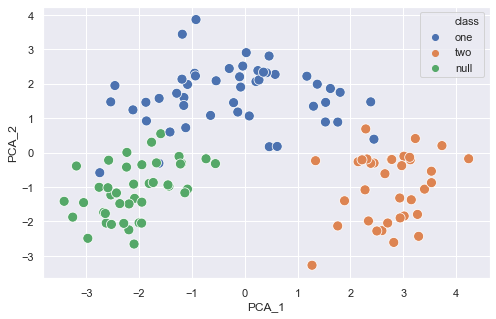

In [238]:
plt.figure(figsize = (8, 5))
sns.scatterplot(train_data['PCA_1'], train_data['PCA_2'], 
                hue = train_data['class'], s = 100)

The first 2 PCAs can very well separate the 3 wine classes. k-means clustering shall have a similar look when applied later.

Seems like the Principal components do a good job of separating the test dataset as well

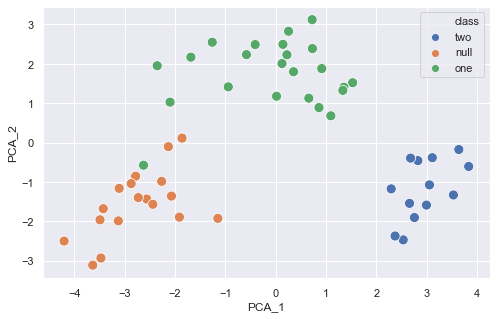

In [253]:
pca_applied_test = pd.DataFrame(pca.transform(X_test_scaled))
pca_applied_test = pca_applied_test[[0, 1, 2]].copy()
pca_applied_test.columns = ['PCA_1', 'PCA_2', 'PCA_3']

X_test_scaled.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)
pca_applied_test.reset_index(inplace = True, drop = True)

test_data = pd.concat([X_test_scaled, pca_applied_test, y_test], 1)

class_dictionary = {0 : 'null', 1 : 'one', 2 : 'two'}
test_data.replace({"class": class_dictionary}, inplace = True)

plt.figure(figsize = (8, 5))
sns.scatterplot(test_data['PCA_1'], test_data['PCA_2'], 
                hue = test_data['class'], s = 100)

#### k-means clustering

In [276]:
km = KMeans(n_clusters = 3, n_init = 20, max_iter = 500, random_state = 20202020)
km.fit(X_train_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=20202020, tol=0.0001, verbose=0)

In [300]:
kmeans_predictions = pd.DataFrame(km.predict(X_train_scaled), columns = ['predicted_class'])
kmeans_predictions = pd.concat([X_train_scaled, pca_applied, kmeans_predictions], 1)
kmeans_predictions.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PCA_1,PCA_2,PCA_3,predicted_class
0,-1.733963,-0.962976,1.245549,0.158942,-0.403110,0.786062,0.940893,-0.602127,1.621288,-1.040225,0.066295,0.923981,-0.211003,-1.870689,1.462316,1.751795,2
1,0.098414,1.404001,-0.033368,0.615163,1.020769,-1.420531,-0.620022,-0.200277,-0.775424,1.945197,-1.662953,-1.749543,-0.643747,3.018578,-1.842515,0.025212,0
2,0.210601,0.490745,0.004247,0.158942,1.545355,-1.022349,-1.344367,1.326754,-0.207314,1.900968,-1.529934,-1.347821,0.321605,2.596693,-2.268208,-0.194625,0
3,-0.711820,-0.683716,-0.296675,0.615163,-1.002638,0.786062,1.175540,0.201573,0.343042,-0.469678,-1.130877,0.342178,-1.302850,-0.210876,1.451483,0.747454,2
4,-1.484660,0.043973,1.396010,0.615163,2.594529,-1.105303,-1.028104,-1.807678,-0.029780,-1.106568,0.021955,-0.461264,-0.394087,0.464560,0.171208,1.883052,2


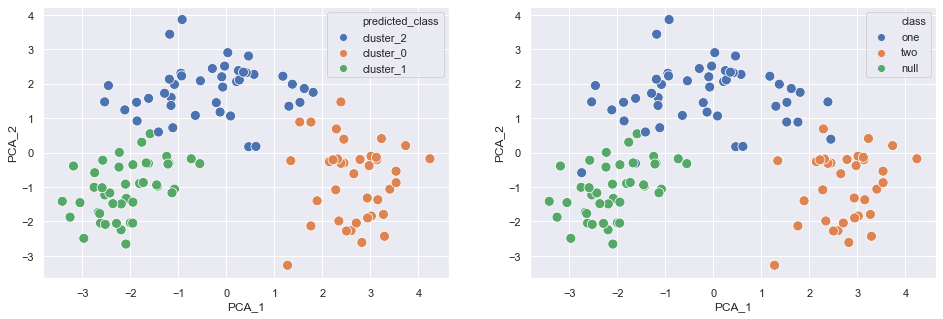

In [301]:
cluster_centers = pd.DataFrame(km.cluster_centers_, columns = X_train_scaled.columns)
cluster_centers = pd.DataFrame(pca.transform(cluster_centers))[[0, 1, 2]]
cluster_centers.columns = ['PCA_1', 'PCA_2', 'PCA_3']

class_dictionary = {0 : 'cluster_0', 1 : 'cluster_1', 2 : 'cluster_2'}
kmeans_predictions.replace({"predicted_class": class_dictionary}, inplace = True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

sns.scatterplot(kmeans_predictions['PCA_1'], kmeans_predictions['PCA_2'], hue = kmeans_predictions['predicted_class'], s = 100, ax = ax1)
#sns.scatterplot(cluster_centers['PCA_1'], cluster_centers['PCA_2'], s = 500, color=".2", marker="X", ax = ax1)
sns.scatterplot(train_data['PCA_1'], train_data['PCA_2'], hue = train_data['class'], s = 100, ax = ax2)

k-means clustering's data separation is very much alike to the actual 3 classes. of course in theory we 'do not know' the labels, but we can check which observations were 'misclustered'

#### Prediction evaluation on train data

In [308]:
class_dictionary = {'cluster_0' : 'two', 'cluster_1' : 'null', 'cluster_2' : 'one'}
kmeans_predictions.replace({"predicted_class": class_dictionary}, inplace = True)

train_data = pd.concat([kmeans_predictions, y_train], 1)

class_dictionary = {0 : 'null', 1 : 'one', 2 : 'two'}
train_data.replace({"class": class_dictionary}, inplace = True)

train_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PCA_1,PCA_2,PCA_3,predicted_class,class
0,-1.733963,-0.962976,1.245549,0.158942,-0.403110,0.786062,0.940893,-0.602127,1.621288,-1.040225,0.066295,0.923981,-0.211003,-1.870689,1.462316,1.751795,one,one
1,0.098414,1.404001,-0.033368,0.615163,1.020769,-1.420531,-0.620022,-0.200277,-0.775424,1.945197,-1.662953,-1.749543,-0.643747,3.018578,-1.842515,0.025212,two,two
2,0.210601,0.490745,0.004247,0.158942,1.545355,-1.022349,-1.344367,1.326754,-0.207314,1.900968,-1.529934,-1.347821,0.321605,2.596693,-2.268208,-0.194625,two,two
3,-0.711820,-0.683716,-0.296675,0.615163,-1.002638,0.786062,1.175540,0.201573,0.343042,-0.469678,-1.130877,0.342178,-1.302850,-0.210876,1.451483,0.747454,one,one
4,-1.484660,0.043973,1.396010,0.615163,2.594529,-1.105303,-1.028104,-1.807678,-0.029780,-1.106568,0.021955,-0.461264,-0.394087,0.464560,0.171208,1.883052,one,one


In [310]:
train_data[train_data['predicted_class'] != train_data['class']]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PCA_1,PCA_2,PCA_3,predicted_class,class
8,-0.450052,-0.946509,-1.312286,-0.814331,0.046536,-0.408485,-0.599617,1.326754,-1.698601,0.330857,0.154974,-1.389379,-0.976627,1.760813,0.886526,-1.488788,two,one
10,-0.013772,-0.488365,0.869397,3.200418,2.969234,1.715154,0.910286,-1.245088,0.680357,-0.730626,1.618184,1.256440,0.804281,-2.743651,-0.583970,3.668148,null,one
38,-1.796288,-0.030941,3.239156,2.744197,1.470414,1.516063,3.144536,0.844534,0.520576,0.441429,-0.066724,1.519637,-0.926695,-1.624091,-0.311455,5.526891,null,one
78,-0.886333,-0.570002,-0.597597,0.280601,0.271359,-1.934850,-0.997497,0.040833,-0.207314,-0.863311,-0.173139,-1.070772,0.421469,1.527207,0.889122,-0.513657,two,one
96,-0.288005,1.117484,-1.462747,-1.057649,-1.452284,-1.055531,-0.762850,0.523053,-1.325780,-0.708512,-1.086537,-0.655199,-1.236274,2.384958,1.474032,-1.936072,two,one
123,0.061019,1.381000,-0.183829,0.919311,-1.077579,-1.022349,-0.415980,1.969714,0.076741,-0.089313,-0.465781,-0.807576,-0.760255,2.445882,0.389075,0.302683,two,one


In [312]:
confusion_matrix(train_data['class'], train_data['predicted_class'])

array([[41,  0,  0],
       [ 2, 42,  4],
       [ 0,  0, 35]], dtype=int64)

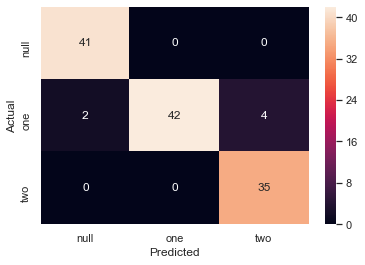

In [315]:
confusion_matrix = pd.crosstab(train_data['class'], train_data['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

#### Prediction evaluation on test data

In [323]:
kmeans_predictions_test = pd.DataFrame(km.predict(X_test_scaled), columns = ['predicted_class'])
kmeans_predictions_test = pd.concat([X_test_scaled, pca_applied_test, kmeans_predictions_test], 1)

test_data = pd.concat([kmeans_predictions_test, y_test], 1)

class_dictionary = {0 : 'two', 1 : 'null', 2 : 'one'}
test_data.replace({"predicted_class": class_dictionary}, inplace = True)

class_dictionary = {0 : 'null', 1 : 'one', 2 : 'two'}
test_data.replace({"class": class_dictionary}, inplace = True)

test_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PCA_1,PCA_2,PCA_3,predicted_class,class
0,-0.188284,1.010901,0.794166,0.767237,0.496182,-1.022349,-1.425984,1.889344,-1.094985,0.255669,-0.332762,-0.669051,-0.577171,2.822846,-0.456626,0.856969,two,two
1,0.908649,-0.727899,1.245549,0.919311,0.121477,1.217426,1.277560,-0.602127,1.426000,0.308743,1.086108,0.162096,1.802922,-2.562087,-1.431120,1.232194,null,null
2,0.497299,1.409715,0.418014,1.071385,0.196418,-0.773485,-1.272953,0.523053,-0.296081,1.016399,-1.086537,-1.430936,0.022013,2.656919,-1.541486,0.407054,two,two
3,0.198136,1.206742,-0.823288,0.463089,0.196418,-1.271213,-1.476994,0.523053,-0.491369,-0.443141,-1.529934,-1.264707,0.288317,2.677675,-0.393137,-0.725692,two,two
4,0.609486,-0.501765,-0.484751,1.375532,-0.927697,-0.640758,-0.160929,-0.762867,-0.970711,-0.558135,0.154974,0.259063,-0.903394,0.656769,1.127646,0.140765,one,one


In [324]:
test_data[test_data['predicted_class'] != test_data['class']]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PCA_1,PCA_2,PCA_3,predicted_class,class
51,-0.66196,-0.698347,-0.635212,-0.145206,4.692876,0.38788,0.277759,-0.361017,3.023808,-1.062339,0.953089,0.051276,0.644499,-2.624955,-0.572883,1.207004,null,one


In [325]:
confusion_matrix(test_data['class'], test_data['predicted_class'])

array([[18,  0,  0],
       [ 1, 22,  0],
       [ 0,  0, 13]], dtype=int64)

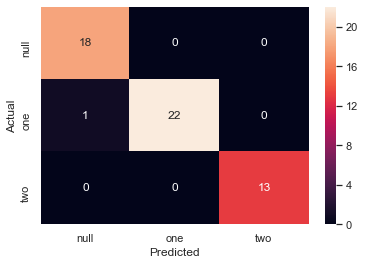

In [326]:
confusion_matrix = pd.crosstab(test_data['class'], test_data['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

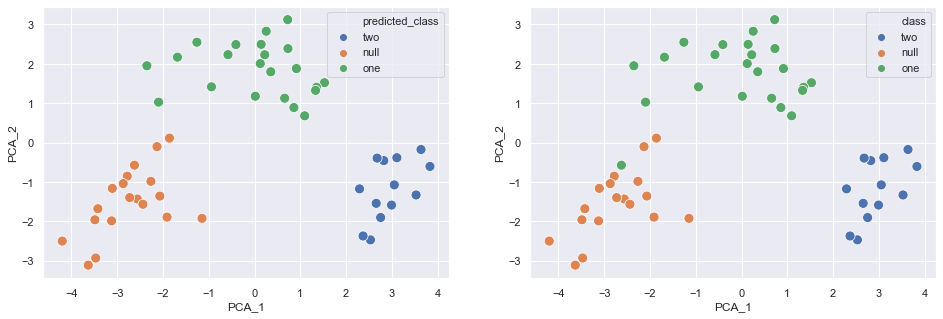

In [338]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

sns.scatterplot(test_data['PCA_1'], test_data['PCA_2'], hue = test_data['predicted_class'], s = 100, ax = ax1)
sns.scatterplot(test_data['PCA_1'], test_data['PCA_2'], hue = test_data['class'], s = 100, ax = ax2)

#### Final evaluation

In [337]:
print('Used simple k-means clustering algo to try and cluster data into 3 groups')
print('To evaluate I compared actual labels (classes) to predicted clusters (in reality that is not feasible)\n')
print('Accuracy on train set: ', round((1 - 6/124) * 100, 2), '%')
print('Accuracy on test set: ', round((1 - 1/54) * 100, 2), '%')

Used simple k-means clustering algo to try and cluster data into 3 groups
To evaluate I compared actual labels (classes) to predicted clusters (in reality that is not feasible)

Accuracy on train set:  95.16 %
Accuracy on test set:  98.15 %


## Apply supervised methods to predict classes

There are 3 classes so this is a multiclass predicion problem

In [37]:
y_train = y_train.astype('category')
y_test = y_test.astype('category')

### Simple decision tree classifier

In [156]:
parameters = {'min_samples_leaf': [10],
              'max_depth': [2, 3, 4, 5],
              'max_features' : [1]}

classifier = DecisionTreeClassifier(random_state = 20202020)

tuner = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'accuracy')

tuner.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=20202020,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5], 'max_features': [1],
 

In [157]:
tuner.best_params_

{'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 10}

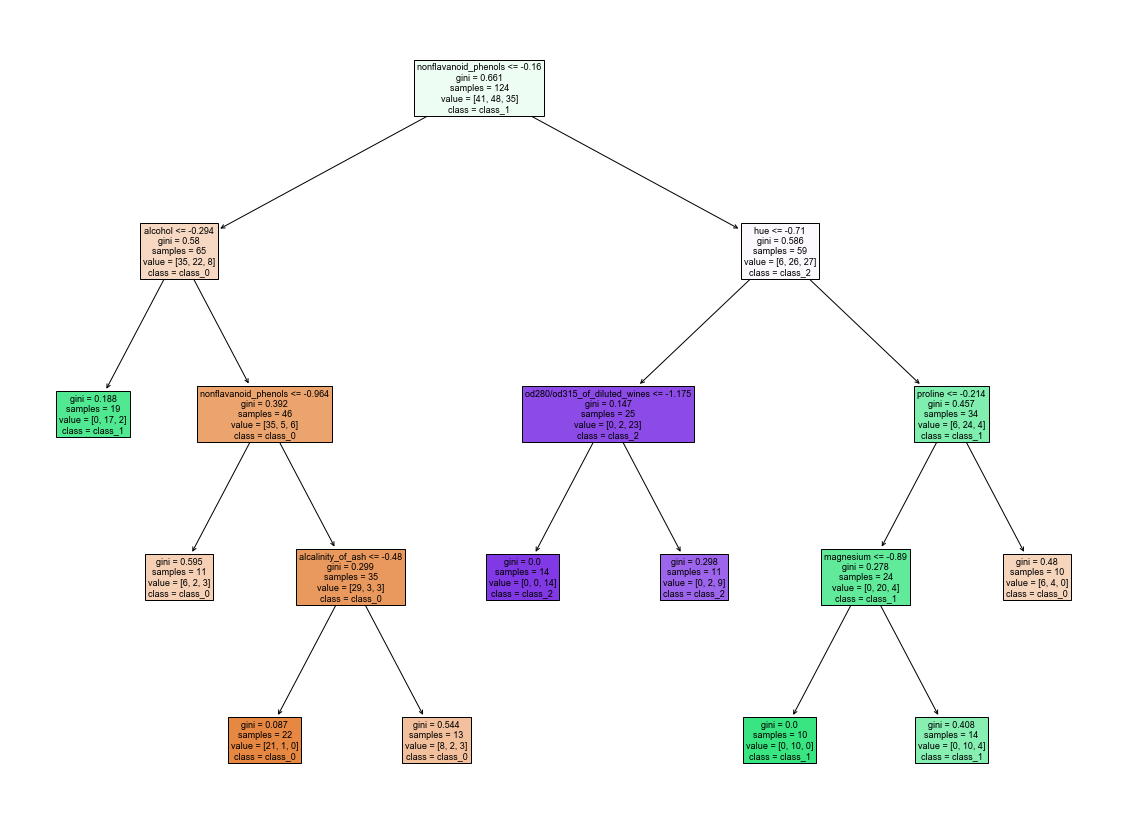

In [158]:
plt.figure(figsize=(20,15))
plt.style.use('grayscale')

plot_tree(tuner.best_estimator_,
          feature_names = X_train_scaled.columns, 
          class_names = ['class_0', 'class_1', 'class_2'],
          filled = True)

plt.show()

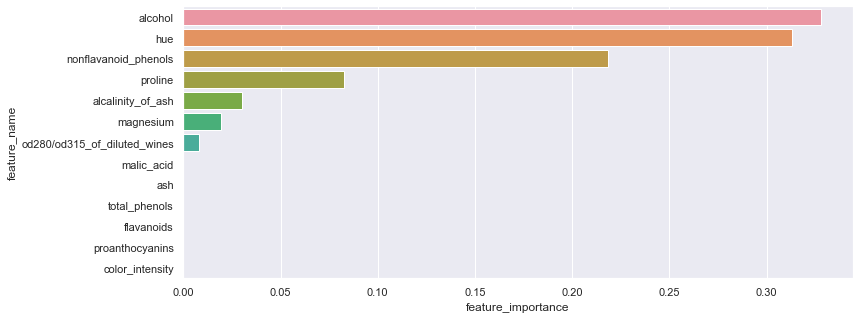

In [159]:
feature_importances = pd.concat([pd.DataFrame(X_train_scaled.columns), pd.DataFrame(tuner.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

sns.set(style="darkgrid")
plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [160]:
confusion_matrix(y_test, tuner.predict(X_test_scaled)) 

array([[18,  0,  0],
       [ 3, 20,  0],
       [ 4,  2,  7]], dtype=int64)

In [161]:
train_acc = round(accuracy_score(y_train, tuner.best_estimator_.predict(X_train_scaled))*100, 3)
test_acc = round(accuracy_score(y_test, tuner.best_estimator_.predict(X_test_scaled))*100, 3)

print('Accuracy on train set with DecisionTreeClassifier: ', train_acc, '%')
print('Accuracy on test set with DecisionTreeClassifier: ', test_acc, '%')

Accuracy on train set with DecisionTreeClassifier:  81.452 %
Accuracy on test set with DecisionTreeClassifier:  83.333 %


### Random Forest Classifier

In [162]:
parameters = {'min_samples_split': [5, 7, 10],
              'max_depth': [5, 7, 9, 11, 13],
              'max_features' : [0.25, 1/3, 0.5, 2/3]}

classifier = RandomForestClassifier(random_state = 20202020, n_estimators = 150)

tuner = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'accuracy')

tuner.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=None,
                                              oob_score=False,
                                              rando

In [163]:
tuner.best_params_

{'max_depth': 5, 'max_features': 0.25, 'min_samples_split': 7}

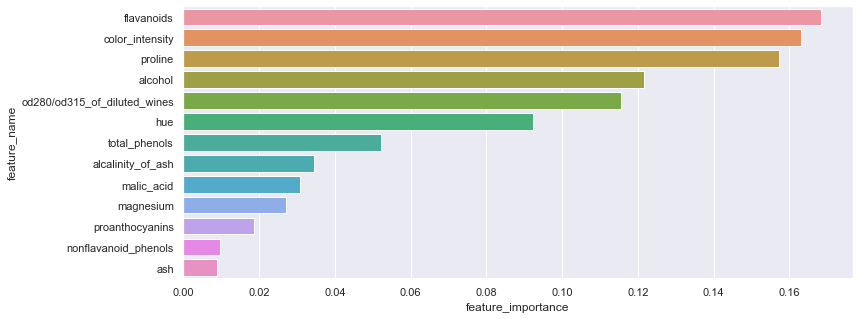

In [164]:
feature_importances = pd.concat([pd.DataFrame(X_train_scaled.columns), pd.DataFrame(tuner.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

sns.set(style="darkgrid")
plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [165]:
confusion_matrix(y_test, tuner.predict(X_test_scaled)) 

array([[18,  0,  0],
       [ 0, 23,  0],
       [ 0,  0, 13]], dtype=int64)

In [167]:
train_acc = round(accuracy_score(y_train, tuner.best_estimator_.predict(X_train_scaled))*100, 3)
test_acc = round(accuracy_score(y_test, tuner.best_estimator_.predict(X_test_scaled))*100, 3)

print('Accuracy on train set with RandomForestClassifier: ', train_acc, '%')
print('Accuracy on test set with RandomForestClassifier: ', test_acc, '%')

Accuracy on train set with RandomForestClassifier:  100.0 %
Accuracy on test set with RandomForestClassifier:  100.0 %


### Gradient Boosting Machine Classifier

In [168]:
parameters = {'min_samples_split': [5, 7, 10],
              'max_depth': [5, 7, 9, 11],
              'max_features' : [0.25, 1/3, 0.5], 
              'subsample' : [0.75, 1],
              'learning_rate' : [0.01]}

classifier = GradientBoostingClassifier(random_state = 20202020, n_estimators = 150)

tuner = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'accuracy')

tuner.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=150,
                                                  n_iter_no_c...
                 

In [177]:
tuner.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 0.25,
 'min_samples_split': 5,
 'subsample': 1}

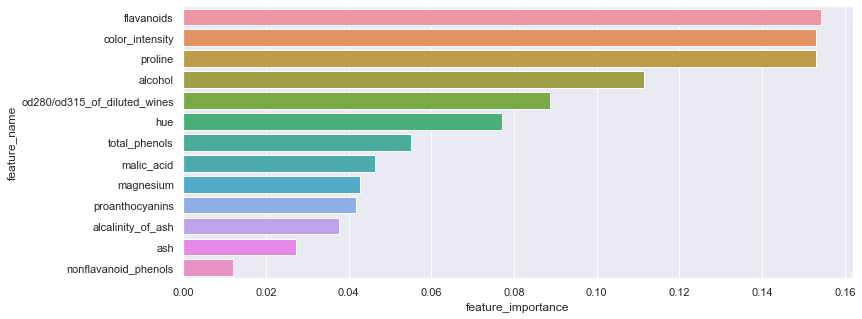

In [178]:
feature_importances = pd.concat([pd.DataFrame(X_train_scaled.columns), pd.DataFrame(tuner.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

sns.set(style="darkgrid")
plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [179]:
confusion_matrix(y_test, tuner.predict(X_test_scaled)) 

array([[18,  0,  0],
       [ 0, 23,  0],
       [ 0,  0, 13]], dtype=int64)

In [180]:
train_acc = round(accuracy_score(y_train, tuner.best_estimator_.predict(X_train_scaled))*100, 3)
test_acc = round(accuracy_score(y_test, tuner.best_estimator_.predict(X_test_scaled))*100, 3)

print('Accuracy on train set with GradientBoostingClassifier: ', train_acc, '%')
print('Accuracy on test set with GradientBoostingClassifier: ', test_acc, '%')

Accuracy on train set with GradientBoostingClassifier:  100.0 %
Accuracy on test set with GradientBoostingClassifier:  100.0 %


### Neural Net

In [175]:
encoder = LabelEncoder()

encoder.fit(y_train)
encoded_y_train = to_categorical(encoder.transform(y_train))
encoded_y_test = to_categorical(encoder.transform(y_test))

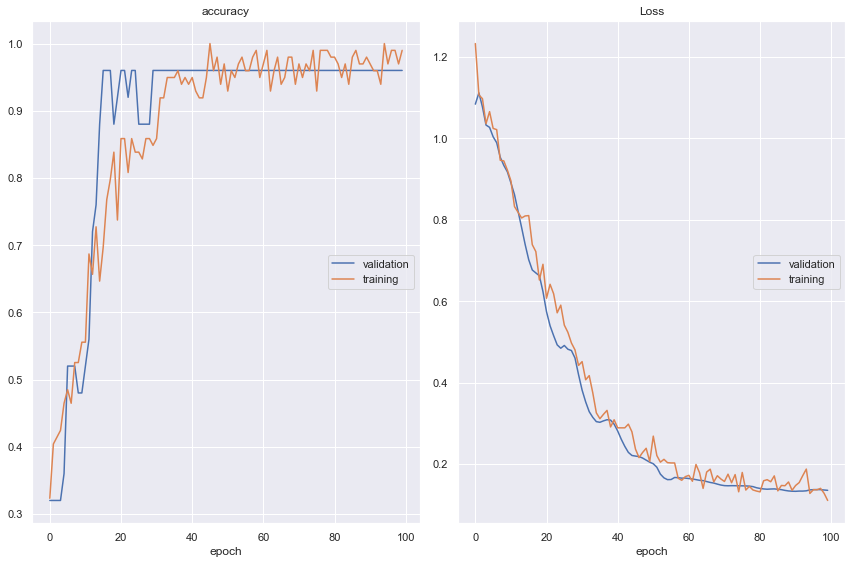

accuracy
	validation       	 (min:    0.320, max:    0.960, cur:    0.960)
	training         	 (min:    0.323, max:    1.000, cur:    0.990)
Loss
	validation       	 (min:    0.133, max:    1.112, cur:    0.135)
	training         	 (min:    0.110, max:    1.233, cur:    0.110)


In [185]:
np.random.seed(20202020)

model = Sequential()

model.add(Dense(128, input_dim = X_train_scaled.shape[1], activation = 'sigmoid', kernel_regularizer = l1(1e-5)))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'sigmoid', kernel_regularizer = l1(1e-5)))
model.add(Dropout(0.25))
model.add(Dense(encoded_y_train.shape[1], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

callbacks = [PlotLossesKeras(),
             EarlyStopping(monitor = 'val_loss', patience = 10),
             ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 1/3)]

model.fit(X_train_scaled, encoded_y_train, batch_size = 32, epochs = 100, validation_split = 0.2, verbose = 1, callbacks = callbacks)

In [188]:
train_acc = model.evaluate(X_train_scaled, encoded_y_train, verbose = 0)[1]
test_acc = model.evaluate(X_test_scaled, encoded_y_test, verbose = 0)[1]

print("Accuracy of Neural Net on train set: ","{:.2%}".format(train_acc))
print("Accuracy of Neural Net on test set: ","{:.2%}".format(test_acc))

Accuracy of Neural Net on train set:  99.19%
Accuracy of Neural Net on test set:  100.00%


### Summary of supervised ML models

1. RandomForest, GBM & Neural Net all achieved 100% test accuracy
2. RandomForest & GBM had the same order of the top 7 (out of 13) most important features
3. Most important variables: flavanoids, color intensity and prolines (alcohol is 4th)

+1. Seems as if the deep learning model assigns larger probabilities to classes - as if it is more sure in its predictions than the gradient boosting machine

In [217]:
predictions_from_gbm = pd.DataFrame(tuner.best_estimator_.predict_proba(X_test_scaled))
predictions_from_gbm.columns = ['GBM prediction for class ' + str(i) for i in range(0,3)]

predictions_from_neuralnet = pd.DataFrame(model.predict_proba(X_test_scaled))
predictions_from_neuralnet.columns = ['Neural net prediction for class ' + str(i) for i in range(0,3)]

predictions = pd.concat([y_test.reset_index(drop = True), predictions_from_gbm, predictions_from_neuralnet], 1)
predictions.head()

,class,GBM prediction for class 0,GBM prediction for class 1,GBM prediction for class 2,Neural net prediction for class 0,Neural net prediction for class 1,Neural net prediction for class 2
0,2,0.061999,0.076596,0.861405,0.007080,0.032595,0.960325
1,0,0.866505,0.080502,0.052993,0.959742,0.035633,0.004624
2,2,0.064071,0.073490,0.862438,0.006854,0.004999,0.988147
3,2,0.074110,0.084713,0.841177,0.008466,0.023090,0.968443
4,1,0.124535,0.734704,0.140761,0.024276,0.926947,0.048778
